<a href="https://colab.research.google.com/github/ccarpenterg/LearningPyTorch1.x/blob/master/06_cifar_10_fine_tuning_pretrained_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## CIFAR-10: Fine-tuning a pre-trained convnet

In [0]:
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch.optim import lr_scheduler

from torchvision import models
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

import statistics

In [2]:
print('PyTorch version:', torch.__version__)
print('Torchvision version:', torchvision.__version__)

PyTorch version: 1.3.1
Torchvision version: 0.4.2


In [0]:
dataset_transform = transforms.Compose([
    transforms.ToTensor()
])

train_set = CIFAR10('./cifar10', train=True, download=True, transform=dataset_transform)
valid_set = CIFAR10('./cifar10', train=False, download=True, transform=dataset_transform)

In [0]:
train_loader = DataLoader(train_set, batch_size=32, num_workers=0, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=32, num_workers=0, shuffle=False)

In [0]:
def train(model, loss_fn, optimizer):

    model.train()
    
    train_batch_losses = []
    
    for batch, labels in train_loader:
        batch = batch.to(cuda)
        labels = labels.to(cuda)
        
        optimizer.zero_grad()
        y_pred = model(batch)
        loss = loss_fn(y_pred, labels)
        loss.backward()
        optimizer.step()
        
        train_batch_losses.append(float(loss))
        
        mean_loss = statistics.mean(train_batch_losses)
        
    return mean_loss

def validate(model, loss_fn, optimizer):

    model.eval()
    
    predictions = []
    
    with torch.no_grad():
        validation_batch_losses = []
        
        for batch, labels in valid_loader:
            batch = batch.to(cuda)
            labels = labels.to(cuda)
            
            labels_pred = model(batch)
            loss = loss_fn(labels_pred, labels)
            
            validation_batch_losses.append(float(loss))
            
            mean_loss = statistics.mean(validation_batch_losses)
            
    return mean_loss

def accuracy(model, loader):
    
    correct = 0
    total = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch, labels in loader:
            batch = batch.to(cuda)
            labels = labels.to(cuda)
        
            labels_pred = model(batch)
        
            _, predicted = torch.max(labels_pred.data, 1)
        
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    return (100 * correct / total)

In [0]:
model = models.resnet18(pretrained=True)

# freezing the resnet by setting requires_grad to False for all parameters
for parameter in model.parameters():
    parameter.requires_grad = False

# we need to know the number of features that are fed to the last dense layer
num_features = model.fc.in_features

# now we remove the ResNet18's classifier and replace it with a 10 classes classifier
model.fc = nn.Linear(num_features, 10)

In [7]:
cuda = torch.device('cuda')

model.to(cuda)

dataiter = iter(train_loader)
batch, labels = next(dataiter)
batch = batch.to(cuda)

output = model(batch)

print(output.shape)

torch.Size([32, 10])


In [8]:
# https://pytorch.org/docs/stable/optim.html#torch.optim.SGD
# Stochastic gradient descent optimizer
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

loss_fn = nn.CrossEntropyLoss()

EPOCHS = 20

train_losses = []
valid_losses = []

train_accuracies = []
valid_accuracies = []

for epoch in range(1, 1 + EPOCHS):
    
    print('Epoch: ', epoch)
    
    train_loss = train(model, loss_fn, optimizer)
    train_accuracy = accuracy(model, train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    exp_lr_scheduler.step()

    print('Training loss:', train_loss)
    print('Training accuracy: {}%'.format(train_accuracy))
    
    valid_loss = validate(model, loss_fn, optimizer)
    valid_accuracy = accuracy(model, valid_loader)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    
    print('Validation loss:', valid_loss)
    print('Validation accuracy: {}%'.format(valid_accuracy))

Epoch:  1
Training loss: 1.7573044793543264
Training accuracy: 44.878%
Validation loss: 1.6498569558603695
Validation accuracy: 43.73%
Epoch:  2
Training loss: 1.6461348545833496
Training accuracy: 45.04%
Validation loss: 1.6270563469146386
Validation accuracy: 44.62%
Epoch:  3
Training loss: 1.6323908844287016
Training accuracy: 46.572%
Validation loss: 1.608224594554962
Validation accuracy: 44.82%
Epoch:  4
Training loss: 1.6298352794927888
Training accuracy: 46.57%
Validation loss: 1.610195259697521
Validation accuracy: 44.61%
Epoch:  5
Training loss: 1.6178465978655385
Training accuracy: 45.902%
Validation loss: 1.6283840333310942
Validation accuracy: 44.06%
Epoch:  6
Training loss: 1.6215711758065057
Training accuracy: 46.148%
Validation loss: 1.610497868480012
Validation accuracy: 44.63%
Epoch:  7
Training loss: 1.6238585553410263
Training accuracy: 45.762%
Validation loss: 1.626687540794714
Validation accuracy: 44.26%
Epoch:  8
Training loss: 1.567732250698087
Training accuracy:

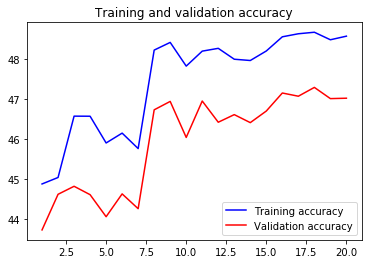

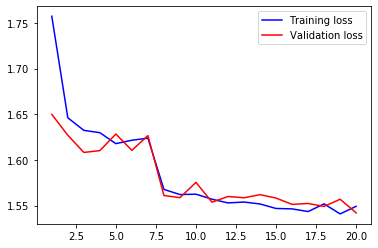

In [9]:
import matplotlib.pyplot as plt

epochs = range(1, 1 + EPOCHS)

plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, valid_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, valid_losses, 'r', label='Validation loss')
plt.legend()

plt.show()